In [44]:
import pandas as pd
import numpy as np
import networkx as nx
import peartree as pear
import partridge as ptg
import matplotlib.pyplot as plt

In [45]:
feed = pear.get_representative_feed("gtfs_subway/")

start = 1  
end = 24*60*60 -1 
G = pear.load_feed_as_graph(feed, start, end).to_undirected()

c:\Users\pacma\OneDrive\Desktop\school\Graph Learning\subway\.venv\Lib\site-packages\peartree\graph.py:197: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for node_id, dist_val in nearest_nodes.iteritems():
c:\Users\pacma\OneDrive\Desktop\school\Graph Learning\subway\.venv\Lib\site-packages\peartree\graph.py:197: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for node_id, dist_val in nearest_nodes.iteritems():
c:\Users\pacma\OneDrive\Desktop\school\Graph Learning\subway\.venv\Lib\site-packages\peartree\graph.py:197: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for node_id, dist_val in nearest_nodes.iteritems():
c:\Users\pacma\OneDrive\Desktop\school\Graph Learning\subway\.venv\Lib\site-packages\peartree\graph.py:197: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for 

In [46]:
stops=list(G.nodes())
connectors = list(G.edges)

In [47]:
stops = [stop[-3:] for stop in stops]
station_data = pd.read_csv("MTA_Subway_Stations.csv")
station_data = station_data[['GTFS Stop ID', 'Complex ID', 'Stop Name', 'Daytime Routes']]

rl = [str(r).split() for r in station_data['Daytime Routes']]
station_data['Daytime Routes'] = rl

In [48]:
# PostProcessing graph
dn = dict(G.nodes.items())
kl = list(dn.keys())
for k in kl:
	m = k[-3:]
	ls = station_data[station_data['GTFS Stop ID'] == m]
	G.nodes[k]['lines'] = ls.iat[0,3]
	G.nodes[k]['GTFS ID'] = ls.iat[0,0]
	G.nodes[k]['Station Name'] = ls.iat[0,2]
	G.nodes[k]['Complex ID'] = ls.iat[0,1]
	try: del G.nodes[k]['modes']
	except KeyError: continue
nx.relabel_nodes(G, lambda x: x[-3:], copy=False)
G.edges.data()
el = list(dict(G.edges.items()))
for e in el:
	try: del G.edges[e]['mode']
	except KeyError: continue

In [49]:
# remove Staten Island Railroad

stps = list(dict(G.nodes.items()).keys())
for stp in stps:
	if 'SIR' in G.nodes[stp]['lines']:
		G.remove_node(stp)


In [50]:
## Add routes to edges
edgelist = G.edges.keys()
for edge in edgelist:
	stop1 = edge[0]
	stop2 = edge[1]
	edge_lines = set(G.nodes[stop1]['lines']).intersection(G.nodes[stop2]['lines'])
	G.edges[edge]['lines'] = edge_lines

G.edges.data()

MultiEdgeDataView([('101', '103', {'length': 120.0, 'lines': {'1'}}), ('103', '104', {'length': 92.57142857142857, 'lines': {'1'}}), ('104', '106', {'length': 90.0, 'lines': {'1'}}), ('106', '107', {'length': 90.0, 'lines': {'1'}}), ('107', '108', {'length': 89.17050691244239, 'lines': {'1'}}), ('108', '109', {'length': 90.0, 'lines': {'1'}}), ('109', '110', {'length': 90.0, 'lines': {'1'}}), ('110', '111', {'length': 90.0, 'lines': {'1'}}), ('111', '112', {'length': 120.0, 'lines': {'1'}}), ('112', '113', {'length': 96.05504587155963, 'lines': {'1'}}), ('113', '114', {'length': 120.0, 'lines': {'1'}}), ('114', '115', {'length': 90.0, 'lines': {'1'}}), ('115', '116', {'length': 101.48648648648648, 'lines': {'1'}}), ('116', '117', {'length': 138.51351351351352, 'lines': {'1'}}), ('117', '118', {'length': 60.0, 'lines': {'1'}}), ('118', '119', {'length': 71.43497757847534, 'lines': {'1'}}), ('119', '120', {'length': 90.0, 'lines': {'1'}}), ('120', '121', {'length': 109.05579399141631, 'l

In [69]:
## transfers in complex
transfers = pd.read_csv('gtfs_subway/transfers.txt')
transfers['lines'] = 0
for i in range(len(transfers['from_stop_id'])):
	coming = transfers['from_stop_id'][i]
	going = transfers['to_stop_id'][i]

	try: 
		d = (G.nodes[coming]['lines'], G.nodes[going]['lines'])
		transfers['lines'][i] = d
	except Exception as e:
		print(e)
		print(coming, going, i)
	
transfers.drop("transfer_type", inplace=True, axis=1)

transfers = transfers[transfers['from_stop_id'] != transfers['to_stop_id']]
transfers.reset_index(inplace=True,drop=True)

C:\Users\pacma\AppData\Local\Temp\ipykernel_27436\1326249141.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transfers['lines'][i] = d


In [ ]:
S = [s for s in nx.connected_components(G)]
## 5 disconnected components without complexes
## S[0] is the IRT
## S[1] is the 7 train, and possibly express?
## S[2] is the 42 street shuttle
## S[3] is the BMT/IND
## S[4] is the L train
import itertools
def iterator(L):
	a, b = itertools.tee(L)
	next(b, None)
	return list(zip(a,b))

transfers

In [78]:
dict(G.nodes.data()).values()

dict_values([{'boarding_cost': {'1': 204.73459715639817}, 'y': 40.889248, 'x': -73.898583, 'lines': ['1'], 'GTFS ID': '101', 'Station Name': 'Van Cortlandt Park-242 St', 'Complex ID': 293}, {'boarding_cost': {'1': 197.94030742775658}, 'y': 40.884667, 'x': -73.90087, 'lines': ['1'], 'GTFS ID': '103', 'Station Name': '238 St', 'Complex ID': 294}, {'boarding_cost': {'1': 197.94030742775658}, 'y': 40.878856, 'x': -73.904834, 'lines': ['1'], 'GTFS ID': '104', 'Station Name': '231 St', 'Complex ID': 295}, {'boarding_cost': {'1': 197.4574428118217}, 'y': 40.874561, 'x': -73.909831, 'lines': ['1'], 'GTFS ID': '106', 'Station Name': 'Marble Hill-225 St', 'Complex ID': 296}, {'boarding_cost': {'1': 194.65328407891528}, 'y': 40.869444, 'x': -73.915279, 'lines': ['1'], 'GTFS ID': '107', 'Station Name': '215 St', 'Complex ID': 297}, {'boarding_cost': {'1': 194.65328407891528}, 'y': 40.864621, 'x': -73.918822, 'lines': ['1'], 'GTFS ID': '108', 'Station Name': '207 St', 'Complex ID': 298}, {'boarding

In [ ]:
complexes = pd.read_csv("MTA_Subway_Stations_and_Complexes_20250918.csv")
complexes = complexes[complexes['Number Of Stations In Complex'] > 1]
complexes = complexes[['Complex ID','Number Of Stations In Complex', 'GTFS Stop IDs']]
gtfs_ids = [ids.split("; ") for ids in complexes['GTFS Stop IDs']]
complex_pairs = [list(itertools.combinations(sts, 2)) for sts in gtfs_ids]
complexes['complex_transfers'] = complex_pairs
complexes = complexes.explode('complex_transfers', ignore_index=True).drop(['Number Of Stations In Complex','GTFS Stop IDs'], axis= 1)
transfer_edges = list(zip(transfers['from_stop_id'], transfers['to_stop_id']))
transfer_edge_set = set()
for k in transfer_edges:
	transfer_edge_set.add(tuple(sorted(k)))

##print(transfer_edge_set ^ set(complexes['complex_transfers']))


##('254', 'L26'), ('629', 'B08'), ('B08', 'R11')##

## Out of station transfers specified on the official map
## Walk Junius to Livonia
## Walk Lexington-59 NRW to Lexington-63 -- 300s
## walk Lexington-59 456 to Lexington-63 -- 300s
transfers['edges'] = [tuple(sorted(k)) for k in transfer_edges]
unique_transfers = transfers.sort_values('edges').iloc[::2,:]
unique_transfers.reset_index(drop=True,inplace=True)
unique_transfers.drop(['from_stop_id', 'to_stop_id'], axis=1, inplace=True)
unique_transfers

,min_transfer_time,lines,edges
0,180,"([1], [A, C])","(112, A09)"
1,180,"([1], [A, C, B, D])","(125, A24)"
2,180,"([7], [1, 2, 3])","(127, 725)"
3,180,"([1, 2, 3], [S])","(127, 902)"
4,300,"([A, C, E], [1, 2, 3])","(127, A27)"
...,...,...,...
71,180,"([N, Q, R, W], [L])","(L03, R20)"
72,180,"([M], [L])","(L17, M08)"
73,180,"([N, Q], [J, Z])","(M20, Q01)"
74,300,"([J, Z], [R, W])","(M20, R23)"


In [175]:
for u, v, data in G.edges(data=True):
    try:
        data["time"] = data.pop("length")
    except: continue
G.edges.data()

MultiEdgeDataView([('101', '103', {'lines': {'1'}, 'time': 120.0}), ('103', '104', {'lines': {'1'}, 'time': 92.57142857142857}), ('104', '106', {'lines': {'1'}, 'time': 90.0}), ('106', '107', {'lines': {'1'}, 'time': 90.0}), ('107', '108', {'lines': {'1'}, 'time': 89.17050691244239}), ('108', '109', {'lines': {'1'}, 'time': 90.0}), ('109', '110', {'lines': {'1'}, 'time': 90.0}), ('110', '111', {'lines': {'1'}, 'time': 90.0}), ('111', '112', {'lines': {'1'}, 'time': 120.0}), ('112', '113', {'lines': {'1'}, 'time': 96.05504587155963}), ('113', '114', {'lines': {'1'}, 'time': 120.0}), ('114', '115', {'lines': {'1'}, 'time': 90.0}), ('115', '116', {'lines': {'1'}, 'time': 101.48648648648648}), ('116', '117', {'lines': {'1'}, 'time': 138.51351351351352}), ('117', '118', {'lines': {'1'}, 'time': 60.0}), ('118', '119', {'lines': {'1'}, 'time': 71.43497757847534}), ('119', '120', {'lines': {'1'}, 'time': 90.0}), ('120', '121', {'lines': {'1'}, 'time': 109.05579399141631}), ('120', '123', {'lin

In [ ]:
fstop = [unique_transfers['edges'][k][0] for k in unique_transfers.index]
tstop = [unique_transfers['edges'][k][1] for k in unique_transfers.index]
ttime = unique_transfers['min_transfer_time']
weighted_edge_list = list(zip(fstop, tstop, ttime))
G.add_weighted_edges_from(weighted_edge_list, weight='time')

In [177]:
G.edges.data()

MultiEdgeDataView([('101', '103', {'lines': {'1'}, 'time': 120.0}), ('103', '104', {'lines': {'1'}, 'time': 92.57142857142857}), ('104', '106', {'lines': {'1'}, 'time': 90.0}), ('106', '107', {'lines': {'1'}, 'time': 90.0}), ('107', '108', {'lines': {'1'}, 'time': 89.17050691244239}), ('108', '109', {'lines': {'1'}, 'time': 90.0}), ('109', '110', {'lines': {'1'}, 'time': 90.0}), ('110', '111', {'lines': {'1'}, 'time': 90.0}), ('111', '112', {'lines': {'1'}, 'time': 120.0}), ('112', '113', {'lines': {'1'}, 'time': 96.05504587155963}), ('112', 'A09', {'time': 180}), ('113', '114', {'lines': {'1'}, 'time': 120.0}), ('114', '115', {'lines': {'1'}, 'time': 90.0}), ('115', '116', {'lines': {'1'}, 'time': 101.48648648648648}), ('116', '117', {'lines': {'1'}, 'time': 138.51351351351352}), ('117', '118', {'lines': {'1'}, 'time': 60.0}), ('118', '119', {'lines': {'1'}, 'time': 71.43497757847534}), ('119', '120', {'lines': {'1'}, 'time': 90.0}), ('120', '121', {'lines': {'1'}, 'time': 109.0557939

In [ ]:
C = [s for s in nx.connected_components(G)]
len(C)

##nx.relabel_nodes(G, lambda x: G.nodes[x]['Complex ID'], copy=False)

5

In [57]:

for st in G.nodes:
	if type(G.nodes[st]['boarding_cost']) is float:
		board_cost = {}
		for line in G.nodes[st]['lines']:
			board_cost[line] = G.nodes[st]['boarding_cost']
		G.nodes[st]['boarding_cost'] = board_cost

In [58]:
cdf = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
##edf = pd.DataFrame.from_dict(dict(G.edges(data=True)), orient='index')
elist = list(G.edges.data())
edict = {}
for i in range(len(elist)):
	start =elist[i][0]
	stop = elist[i][1]
	data = elist[i][2]
	edict[(start, stop)] = data

cdf

,boarding_cost,y,x,lines,GTFS ID,Station Name,Complex ID
101,{'1': 204.73459715639817},40.889248,-73.898583,[1],101,Van Cortlandt Park-242 St,293
103,{'1': 197.94030742775658},40.884667,-73.900870,[1],103,238 St,294
104,{'1': 197.94030742775658},40.878856,-73.904834,[1],104,231 St,295
106,{'1': 197.4574428118217},40.874561,-73.909831,[1],106,Marble Hill-225 St,296
107,{'1': 194.65328407891528},40.869444,-73.915279,[1],107,215 St,297
...,...,...,...,...,...,...,...
R44,{'R': 290.9320408163265},40.622687,-74.028398,[R],R44,86 St,38
R45,{'R': 290.9320408163265},40.616622,-74.030876,[R],R45,Bay Ridge-95 St,39
S01,{'S': 361.5042366946779},40.680596,-73.955827,[S],S01,Franklin Av,627
S03,{'S': 359.9916666666668},40.674772,-73.957624,[S],S03,Park Pl,141


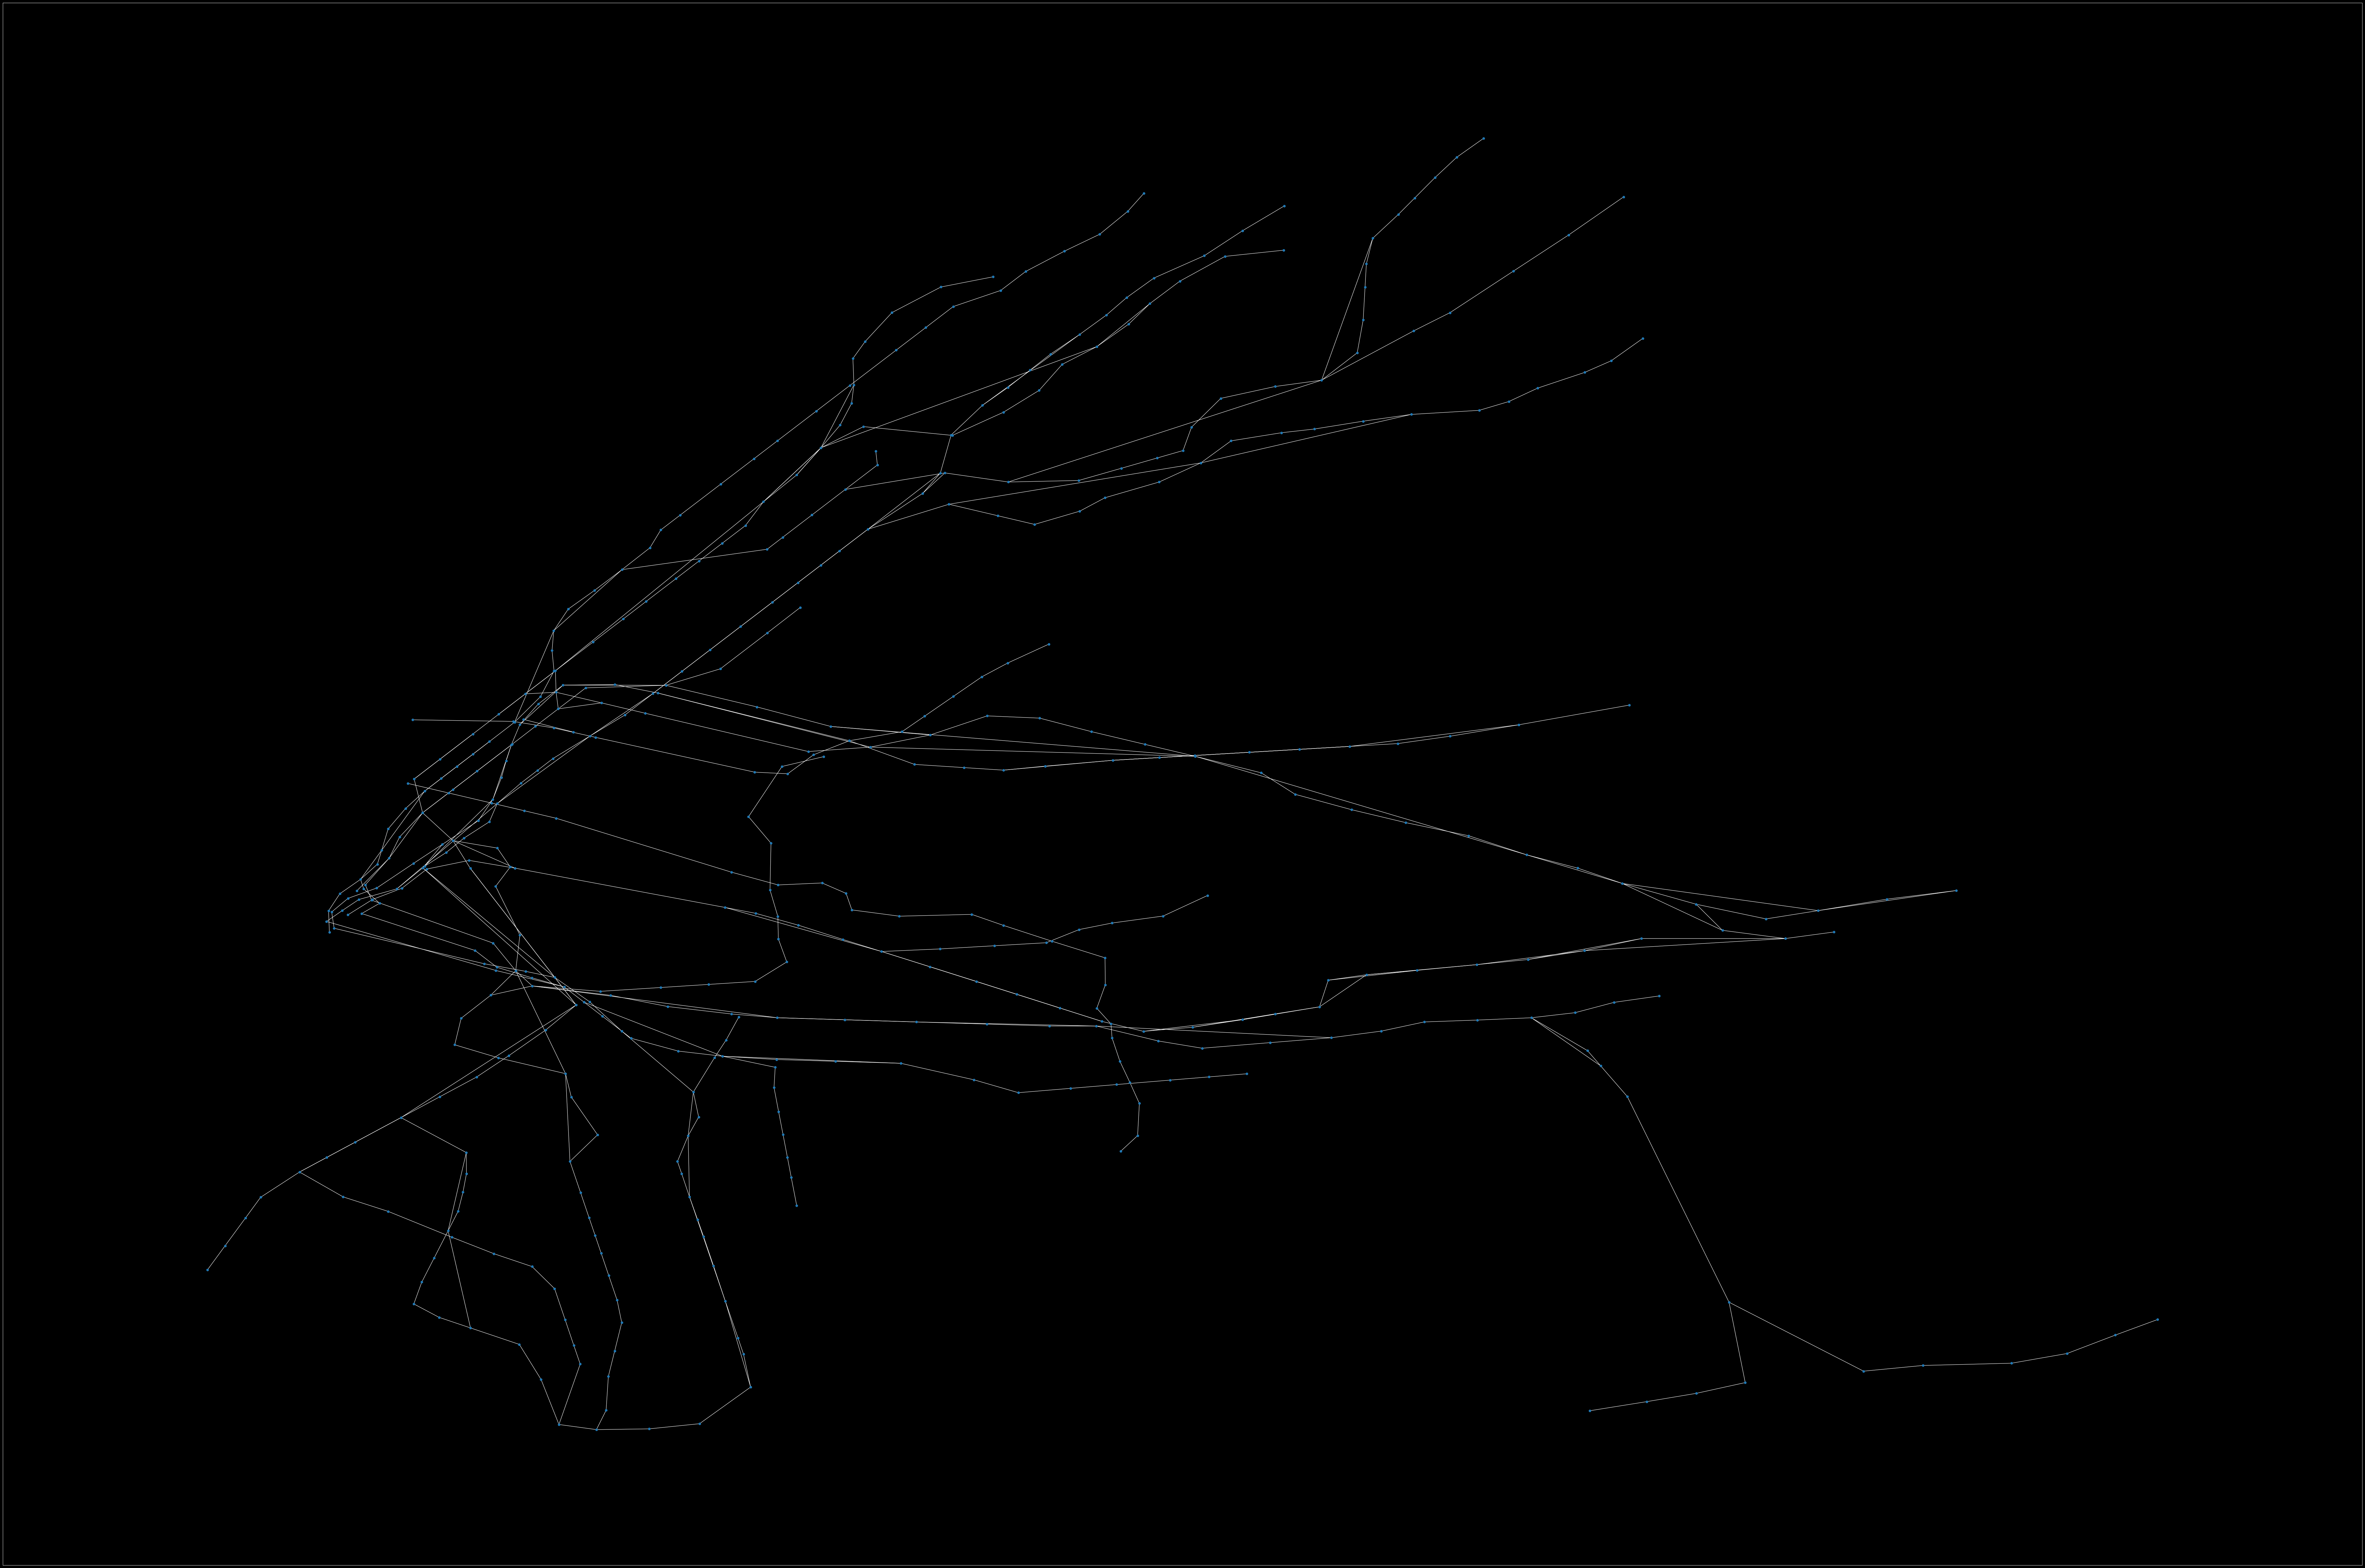

In [59]:
node_pos = dict(G.nodes.data())
st_pos = pd.DataFrame.from_dict(node_pos).T
st_pos = st_pos[['x','y']].T.to_dict()
coords = [list(list(st_pos.values())[n].values()) for n in range(len(st_pos))]
xylist = np.transpose(coords)
xrange = [min(xylist[0]),max(xylist[0])]
yrange = [min(xylist[1]),max(xylist[1])]
xylist[0] += 74
xylist[1] -= 40
xylist[0]*=10
coords = np.transpose(xylist)
coords = [tuple(i) for i in coords]
coords_rd = []
for x,y in coords:
	coords_rd.append((10*round(x,7), 10*round(y,7)))
coords_rd = dict(zip(G.nodes(), coords_rd))
plt.figure(1, figsize=(108,72))
pos = coords_rd

##nx.relabel_nodes(G, lambda x: G.nodes[x]['Complex ID'], copy=False)
nx.draw_networkx(G, with_labels=False, node_size=30, edge_color='w', pos=pos, width=1)



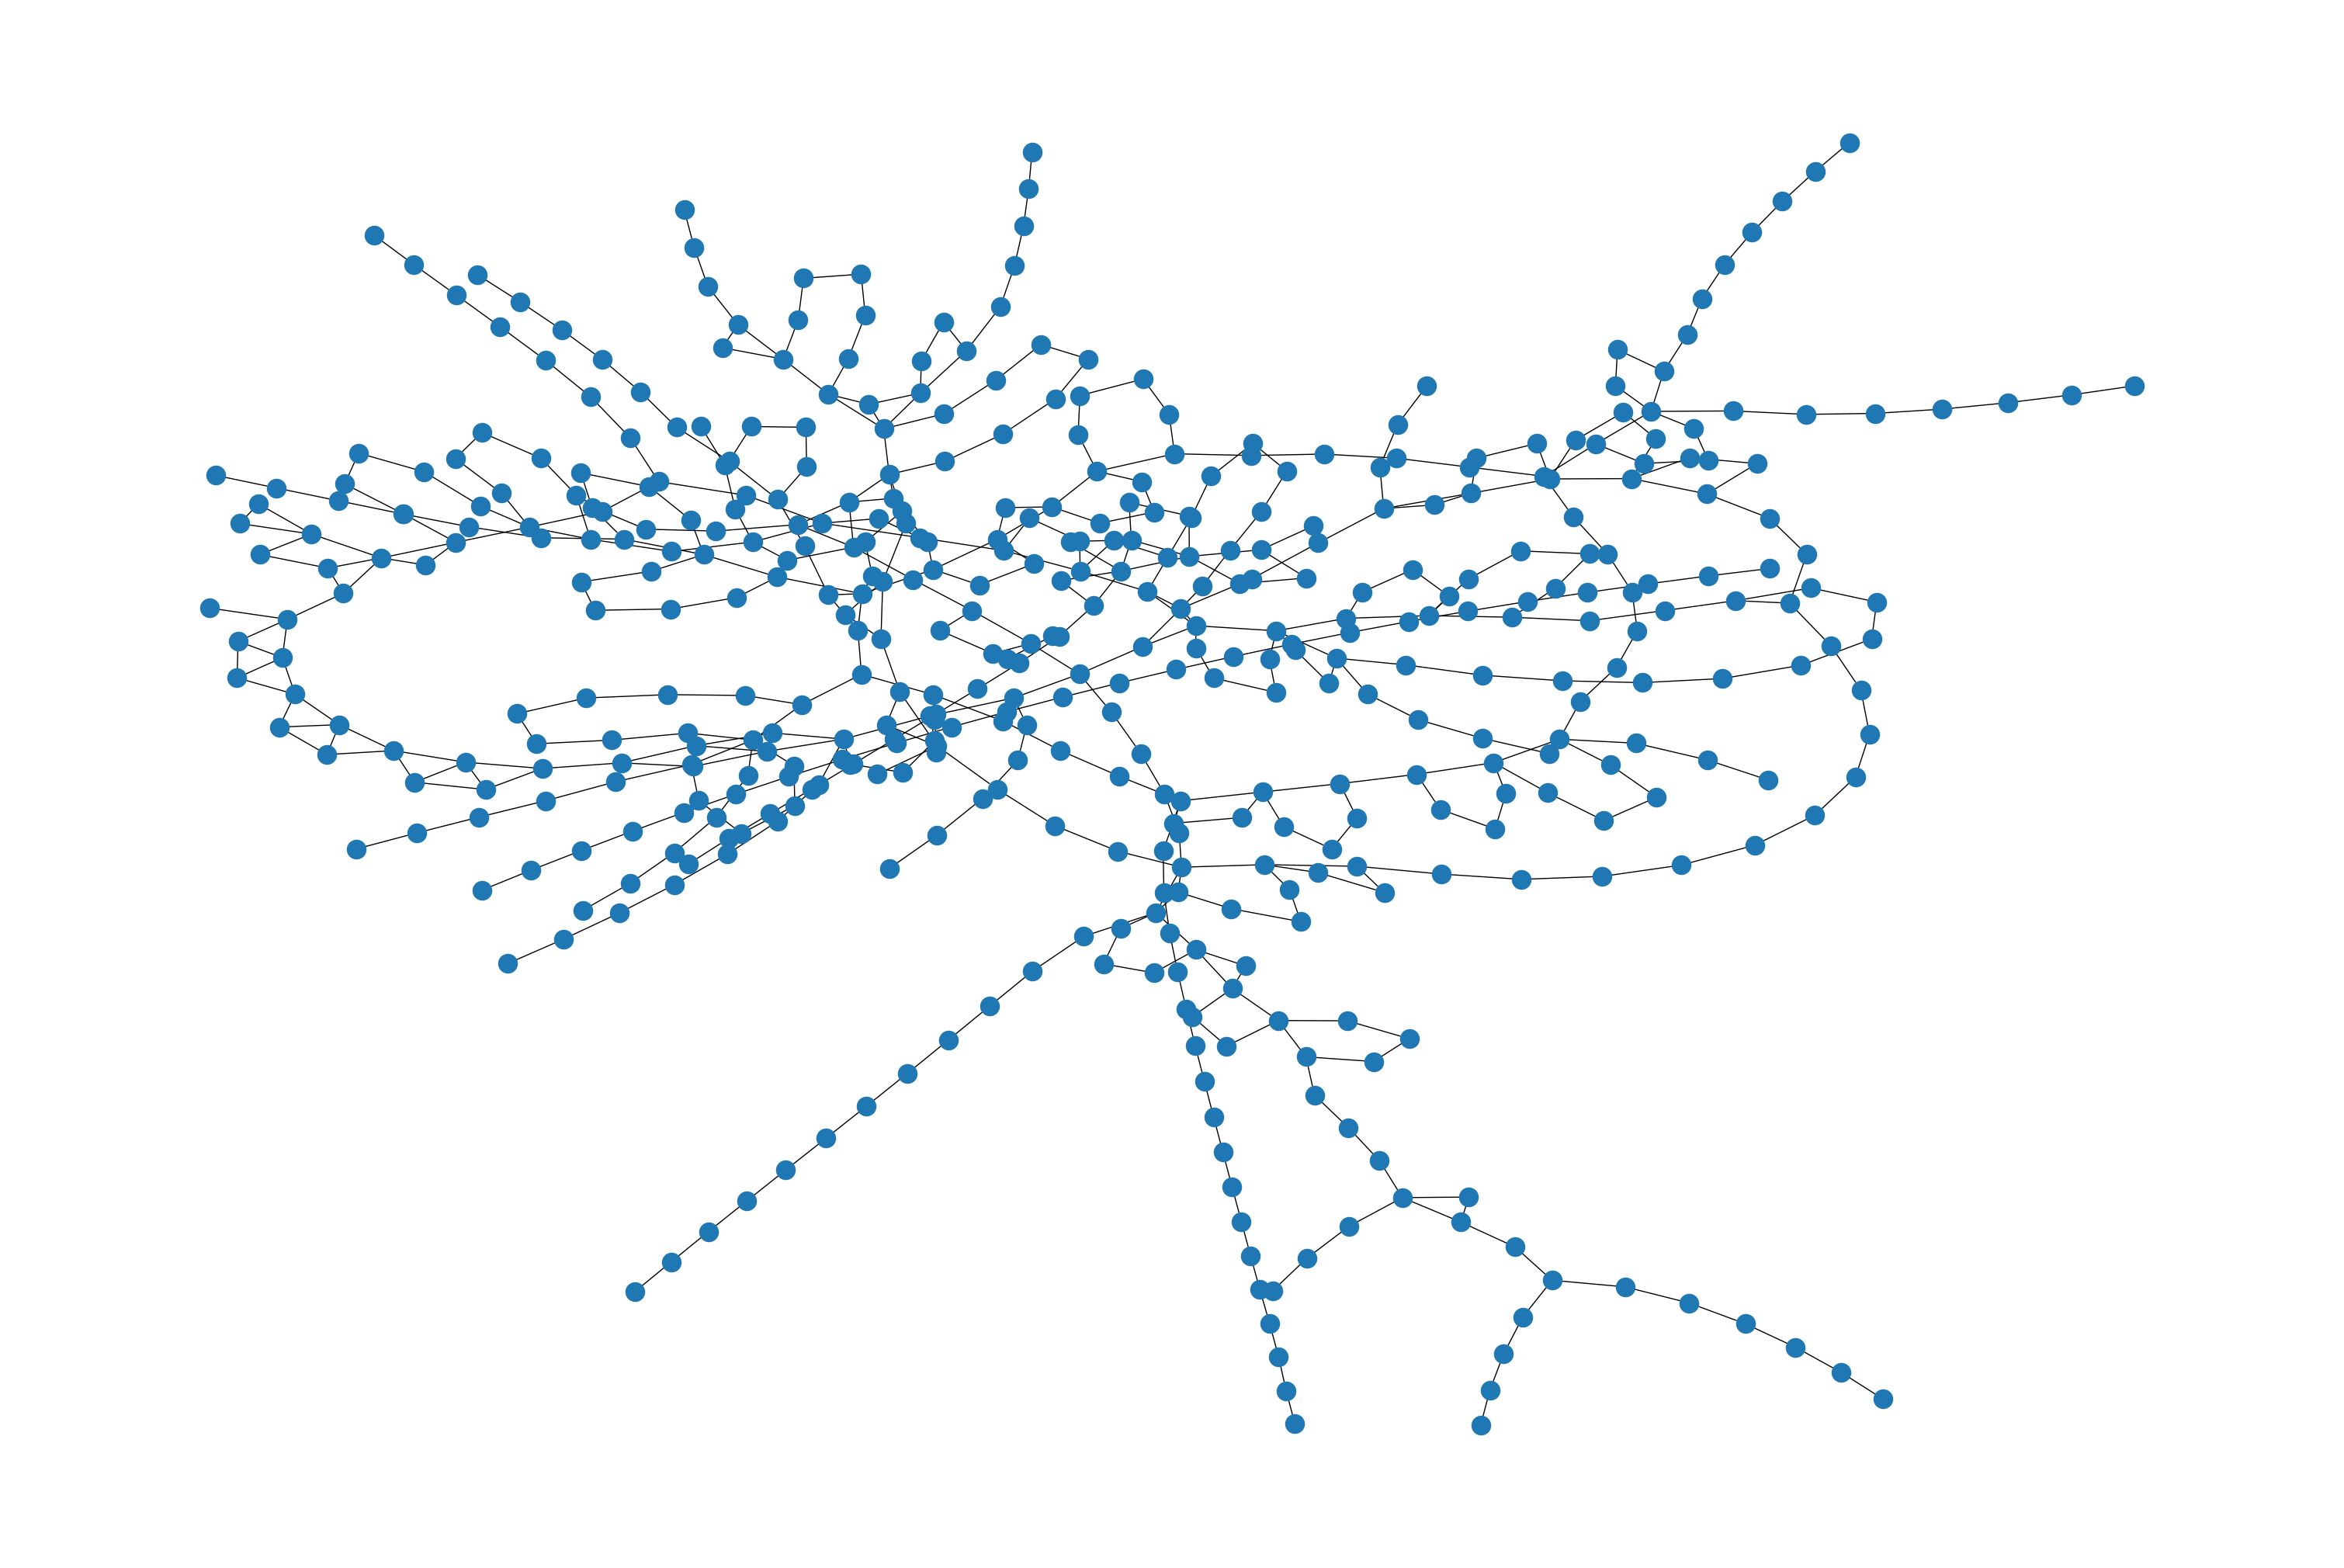

In [60]:

plt.figure(2, figsize=(30,20))
nx.draw_kamada_kawai(G)
##nx.draw_networkx(G, with_labels=False, node_size=30, edge_color='w' width=1)